In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools
from abc import abstractmethod

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## StimulusGenerator

Abstract class that describes what we want out of a generator class

In [4]:
DEFAULT_CANVAS_SIZE = (224, 224)

NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class StimulusGenerator:
    def __init__(self, dtype):
        self.dtype = dtype
    
    @abstractmethod
    def generate(self, target_position, reference_positions) -> torch.Tensor:
        pass
    
    def __call__(self, target_position, reference_positions) -> torch.Tensor:
        return NORMALIZE(self.generate(target_position, reference_positions))
        
    def batch_generate(self, target_positions, reference_positions) -> torch.Tensor:
        if len(reference_positions) != len(target_positions):
            reference_positions = [reference_positions] * len(target_positions)
        return torch.stack([NORMALIZE(self.generate(t, p)) for (t, p) in zip(target_positions, reference_positions)])
    
    def _to_tensor(self, t):
        return torch.tensor(t, dtype=self.dtype)
    
    def _validate_input_to_tuple(self, input_value, n_args=2):
        if not hasattr(input_value, '__len__') or len(input_value) == 1:
            return (input_value, ) * n_args
        
        return input_value
    

class NaiveStimulusGenerator(StimulusGenerator):
    def _validate_color_input(self, c):
        if isinstance(c, str):
            t = self._to_tensor(colors.to_rgb(c))
        else:
            t = self.to_tensor(self._validate_input_to_tuple(c, 3))
        
        return t.view(3, 1, 1)
    
    def __init__(self, target_size, reference_size, canvas_size=DEFAULT_CANVAS_SIZE,
                 target_color='red', reference_color='blue', background_color='white',
                 dtype=torch.float64):
        super(NaiveStimulusGenerator, self).__init__(dtype)
        
        self.target_size = self._validate_input_to_tuple(target_size)
        self.reference_size = self._validate_input_to_tuple(reference_size)
        self.canvas_size = self._validate_input_to_tuple(canvas_size)
        
        self.target_color = self._validate_color_input(target_color)
        self.reference_color = self._validate_color_input(reference_color)
        self.background_color = self._validate_color_input(background_color)
        
    def generate(self, target_position, reference_positions) -> torch.Tensor:
        x = torch.ones(3, *self.canvas_size, dtype=self.dtype) * self.background_color
        x[:, target_position[0]:target_position[0] + self.target_size[0],
             target_position[1]:target_position[1] + self.target_size[1]] = self.target_color
        
        for ref_pos in reference_positions:
            x[:, ref_pos[0]:ref_pos[0] + self.reference_size[0],
                 ref_pos[1]:ref_pos[1] + self.reference_size[1]] = self.reference_color
            
        return x

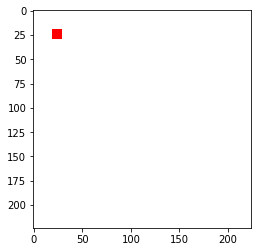

torch.Size([1764, 3, 224, 224])

In [5]:
gen = NaiveStimulusGenerator(10, (10, 100), dtype=torch.float32)
x = gen.generate((20, 20), [])
plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

every = 5
target_positions = [(r * every, c * every) for r, c in itertools.product(range(214 // every), range(214 // every))]
reference_positions = []
batch = gen.batch_generate(target_positions, reference_positions)
batch.shape

In [6]:
target_pos_array = np.array(target_positions)
target_pos_distances = np.linalg.norm(target_pos_array[:, None, :] - target_pos_array[None, :, :], axis=-1)
target_pos_distances /= np.max(target_pos_distances)
upper_triangle_indices = np.triu_indices_from(target_pos_distances, 1)

In [7]:
BATCH_SIZE = 64
dataloader = DataLoader(TensorDataset(batch), batch_size=BATCH_SIZE)

In [8]:
model = models.resnet18(pretrained=True)
model = model.to(device)
model.fc_backup = model.fc
model.fc = nn.Sequential()

In [9]:
embeddings = []
for b in dataloader:
    embeddings.append(model(b[0].to(device)).detach())


embeddings = torch.cat(embeddings)
embeddings.shape

torch.Size([1764, 512])

In [10]:
cos = nn.CosineSimilarity(dim=-1)
embedding_pairwise_cosine = cos(embeddings[:, None, :], embeddings[None, :, :])

embedding_cosine_arr = embedding_pairwise_cosine[upper_triangle_indices].cpu().numpy()
embedding_cosine_arr = (embedding_cosine_arr - embedding_cosine_arr.mean()) / embedding_cosine_arr.std()

target_distance_arr = target_pos_distances[upper_triangle_indices]
target_distance_arr = (target_distance_arr - target_distance_arr.mean()) / target_distance_arr.std()

np.corrcoef(embedding_cosine_arr, target_distance_arr)

array([[1.        , 0.07058345],
       [0.07058345, 1.        ]])

In [ ]:
pca = skl

In [11]:
tsne = TSNE(n_jobs=4, init='pca', random_state=RANDOM_SEED)
tsne_out = tsne.fit_transform(embeddings.cpu().numpy())
tsne_out.shape

AssertionError: init must be 'random' or array

In [ ]:
row_colors = np.array([x[0] for x in target_positions])
row_colors = row_colors / row_colors.max()

col_colors = np.array([x[1] for x in target_positions])
col_colors = col_colors / col_colors.max()

In [ ]:
plt.figure(figsize=(20, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')

row_color_ax = plt.subplot(1, 2, 1)
mappable = row_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=row_colors, cmap=cmap)
row_color_ax.set_title('Color by row')

col_color_ax = plt.subplot(1, 2, 2)
col_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=col_colors, cmap=cmap)
col_color_ax.set_title('Color by column')

plt.colorbar(mappable)
plt.show()

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg.fc_backup = vgg.classifier[6]
vgg.classifier[6] = nn.Sequential()
vgg = vgg.to(device)

In [ ]:
vgg_embeddings = []
for b in dataloader:
    vgg_embeddings.append(vgg(b[0].to(device)).detach())


vgg_embeddings = torch.cat(vgg_embeddings)
vgg_embeddings.shape

In [ ]:
cos = nn.CosineSimilarity(dim=-1)
cosines = []
for i in range(vgg_embeddings.shape[0]):
    remainder = vgg_embeddings[i + 1:, :]
    current = vgg_embeddings[i,:].repeat(remainder.shape[0], 1)

    cosines.append(cos(current, remainder))

embedding_cosine_arr = torch.cat(cosines).cpu().numpy()
embedding_cosine_arr = (embedding_cosine_arr - embedding_cosine_arr.mean()) / embedding_cosine_arr.std()

target_distance_arr = target_pos_distances[upper_triangle_indices]
target_distance_arr = (target_distance_arr - target_distance_arr.mean()) / target_distance_arr.std()

np.corrcoef(embedding_cosine_arr, target_distance_arr)

In [ ]:
vgg_tsne = TSNE(n_jobs=4, init='pca', random_state=RANDOM_SEED)
vgg_tsne_out = vgg_tsne.fit_transform(vgg_embeddings.cpu().numpy())
vgg_tsne_out.shape

In [ ]:
plt.figure(figsize=(20, 8))
cmap = matplotlib.cm.get_cmap('Spectral_r')

row_color_ax = plt.subplot(1, 2, 1)
mappable = row_color_ax.scatter(vgg_tsne_out[:, 0], vgg_tsne_out[:, 1], c=row_colors, cmap=cmap)
row_color_ax.set_title('Color by row')

col_color_ax = plt.subplot(1, 2, 2)
col_color_ax.scatter(vgg_tsne_out[:, 0], vgg_tsne_out[:, 1], c=col_colors, cmap=cmap)
col_color_ax.set_title('Color by column')

plt.colorbar(mappable)
plt.show()